In [79]:
import netCDF4
from pathlib import Path

#patch = netCDF4.Dataset(Path('data/2020_31TCG_patch_14_14.nc'), 'r')
patch = netCDF4.Dataset(Path('dataset/netcdf/2019_31TBF_patch_17_13.nc'), 'r')
patch

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: S4A Patch Dataset
    authors: Papoutsis I., Sykas D., Zografakis D., Sdraka M.
    patch_full_name: 2019_31TBF_patch_17_13
    patch_year: 2019
    patch_name: patch_17_13
    patch_country_code: ES
    patch_tile: 31TBF
    creation_date: 27 Apr 2021
    references: Documentation available at .
    institution: National Observatory of Athens.
    version: 21.03
    _format: NETCDF4
    _nco_version: netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)
    _xarray_version: 0.17.0
    dimensions(sizes): 
    variables(dimensions): 
    groups: B01, B02, B03, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A, labels, parcels

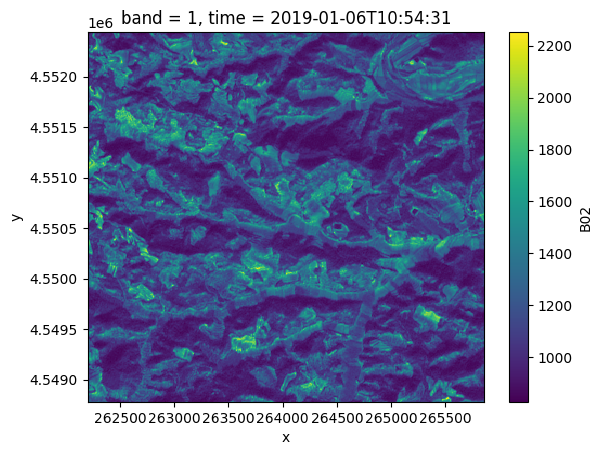

In [186]:
import xarray as xr

band_data = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02']))
band_data.B02.isel(time=0).plot()

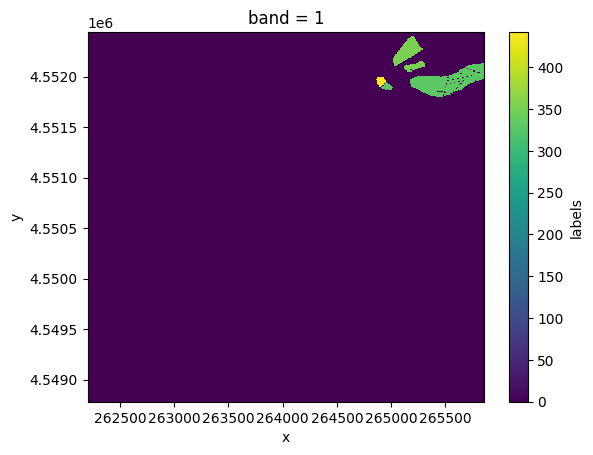

In [187]:
labels = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels']))
labels.labels.plot()

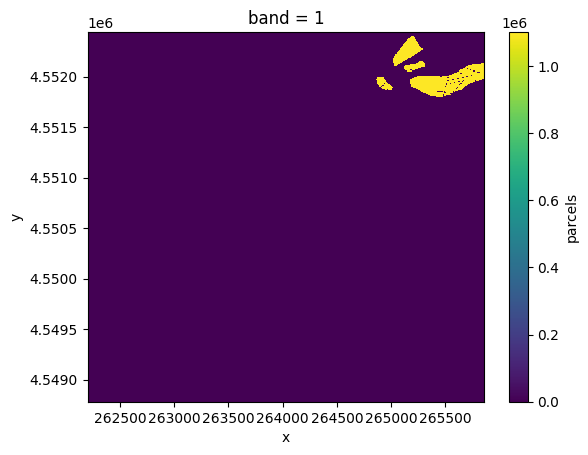

In [188]:
parcels = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['parcels']))
parcels.parcels.plot()

In [189]:
parcels.parcels[0,0]

<xarray.DataArray 'parcels' ()> Size: 4B
[1 values with dtype=uint32]
Coordinates:
    band     int64 8B ...
    y        float64 8B 4.552e+06
    x        float64 8B 2.622e+05
Attributes:
    transform:      [ 1.00000e+01  0.00000e+00  2.62200e+05  0.00000e+00 -1.0...
    crs:            +init=epsg:32631
    res:            [10. 10.]
    is_tiled:       0
    nodatavals:     nan
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area

In [190]:
import pandas as pd
# Or maybe aggregate based on a given frequency
# Refer to
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
group_freq = '1MS'

# Grab year from netcdf4's global attribute
year = patch.patch_year

# output intervals
date_range = pd.date_range(start=f'{year}-01-01', end=f'{int(year) + 1}-01-01', freq=group_freq)

# Aggregate based on given frequency
band_data = band_data.groupby_bins(
    'time',
    bins=date_range,
    right=True,
    include_lowest=False,
    labels=date_range[:-1]
).median(dim='time')

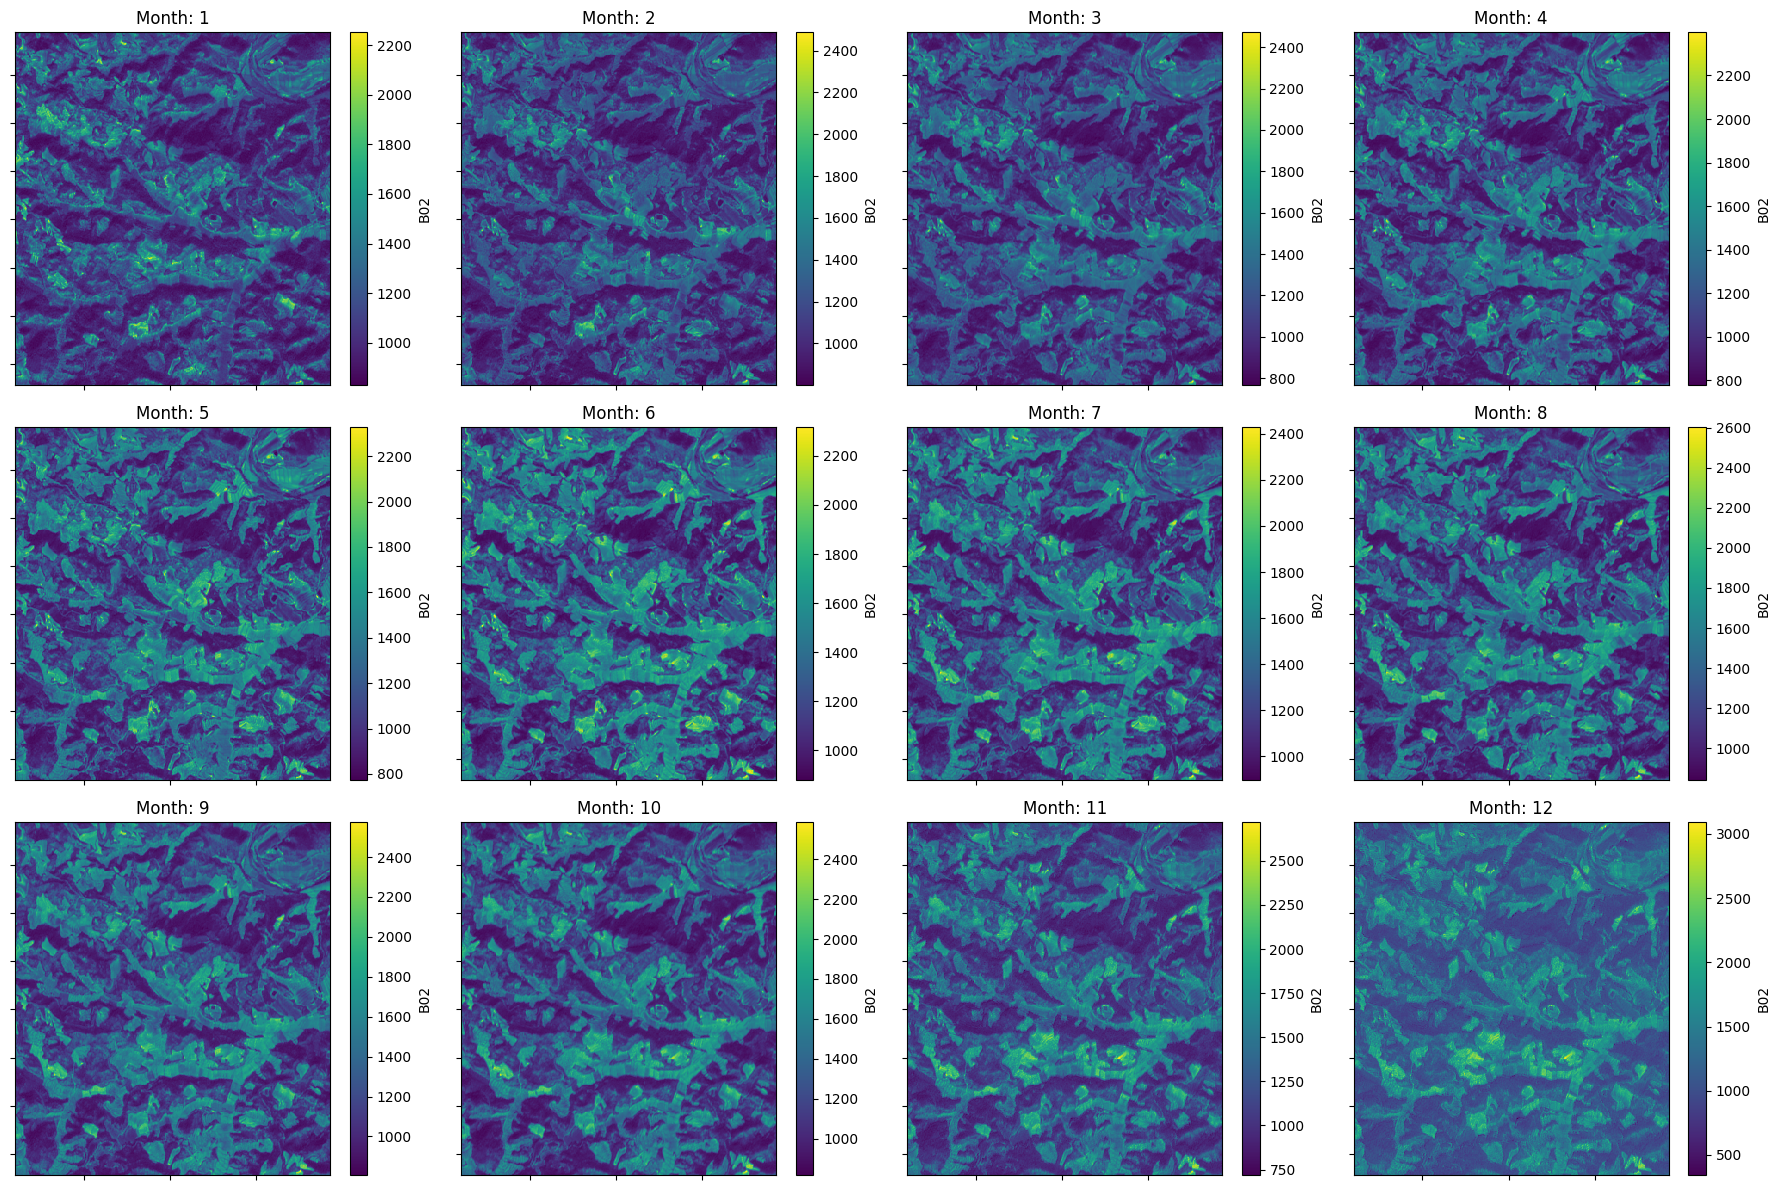

In [191]:
import matplotlib.pyplot as plt

band_data = band_data.interpolate_na(dim='time_bins', method='linear', fill_value='extrapolate')

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))

for i, season in enumerate(band_data.B02):

    ax = axes.flat[i]
    cax = band_data.B02.isel(time_bins=i).plot(ax=ax)


for i, ax in enumerate(axes.flat):
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Month: {i+1}')


plt.tight_layout()
plt.show()

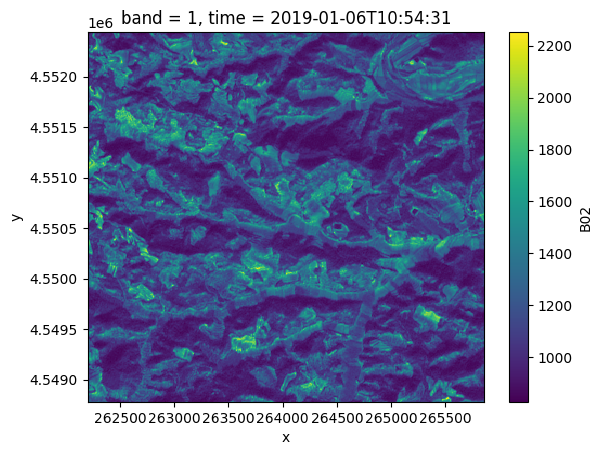

In [192]:
band_data_B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02']))
band_data_B02.B02.isel(time=0).plot()

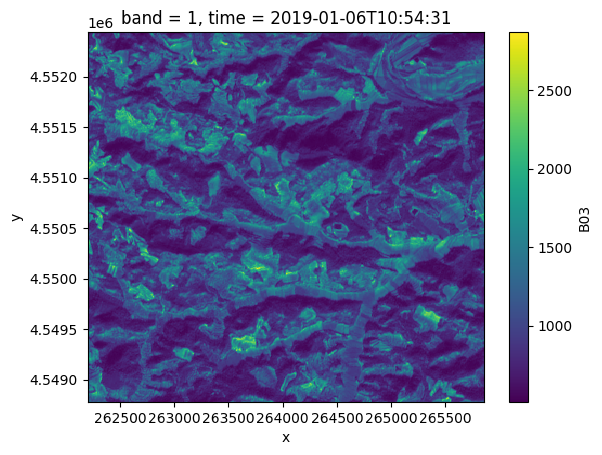

In [193]:
band_data_B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03']))
band_data_B03.B03.isel(time=0).plot()

In [174]:
fB03 = band_data_B03.B03.isel(time=0)
print(type(fB03), fB03.shape, fB03.dtype)

<class 'xarray.core.dataarray.DataArray'> (366, 366) uint16


In [175]:
fB03[0:2,0:3]

<xarray.DataArray 'B03' (y: 2, x: 3)> Size: 12B
[6 values with dtype=uint16]
Coordinates:
    band     int64 8B ...
  * y        (y) float64 16B 4.552e+06 4.552e+06
  * x        (x) float64 24B 2.622e+05 2.622e+05 2.622e+05
    time     datetime64[ns] 8B 2019-01-06T10:54:31
Attributes:
    transform:      [ 1.00000e+01  0.00000e+00  2.62200e+05  0.00000e+00 -1.0...
    crs:            +init=epsg:32631
    res:            [10. 10.]
    is_tiled:       0
    nodatavals:     nan
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area

In [176]:
import numpy as np

## Attempt to combine Blue, Green, and Red channels into an RGB image

In [177]:
band_B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02.isel(time=0)
band_B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03.isel(time=0)
band_B04 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04.isel(time=0)

print(f'max: B02: {np.max(np.array(band_B02))}, B03: {np.max(np.array(band_B03))}, B04: {np.max(np.array(band_B04))}')

max: B02: 2252, B03: 2869, B04: 3827


### dtype is 16 bits.  It appears that the upper 4 are not used

Shift right 4 and convert to uint8 for RGB display

In [178]:
fBlue = np.array((band_B02 / 8).astype(np.uint8))
fGreen = np.array((band_B03 / 8).astype(np.uint8))
fRed = np.array((band_B04 / 8).astype(np.uint8))

### Show a single channel as grayscale

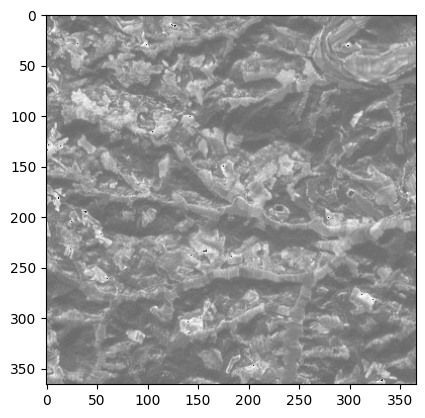

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.imshow(fBlue, cmap='gray')

### Combined and display channels

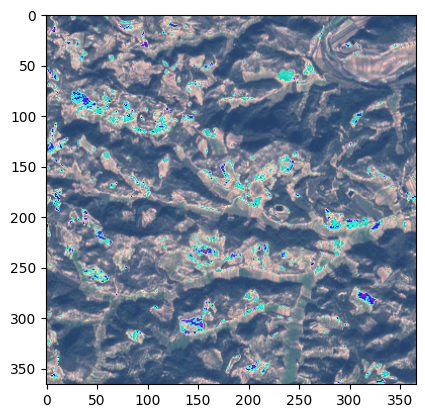

In [180]:
rgb = np.zeros((fBlue.shape[0], fBlue.shape[1],3), 'uint8')
rgb[:, :, 0] = fRed
rgb[:, :, 1] = fGreen
rgb[:, :, 2] = fBlue
plt.imshow(rgb)
#plt.imshow(fRed, cmap='gray')

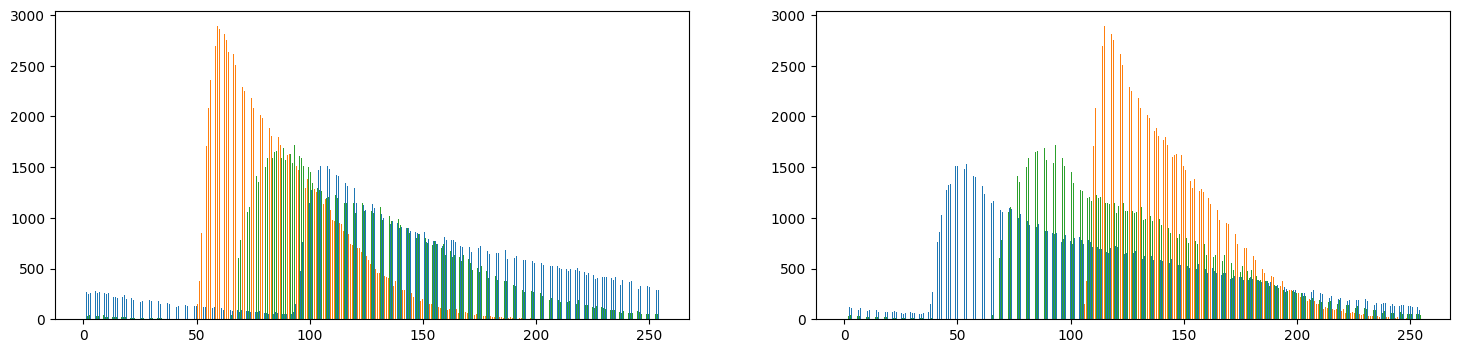

In [182]:
rgb2 = np.dstack((fRed, fGreen, fBlue))
rgb2.shape
from PIL import Image

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
#ax0 = axes[0].hist([fRed.flatten()], bins=256)
ax0 = axes[0].hist([(fRed-200).flatten(), (fBlue+200).flatten(), fGreen.flatten()], bins=256)

from mpl_toolkits.axes_grid1 import axes_grid
ax1 = axes[1].hist([fRed.flatten(), fBlue.flatten(), fGreen.flatten()], bins=256)


['B02 - Blue', 'B03 - Green', 'B04 - Red', 'B08 - NIR']
(366, 366), float64
xlim: 0 - 3827


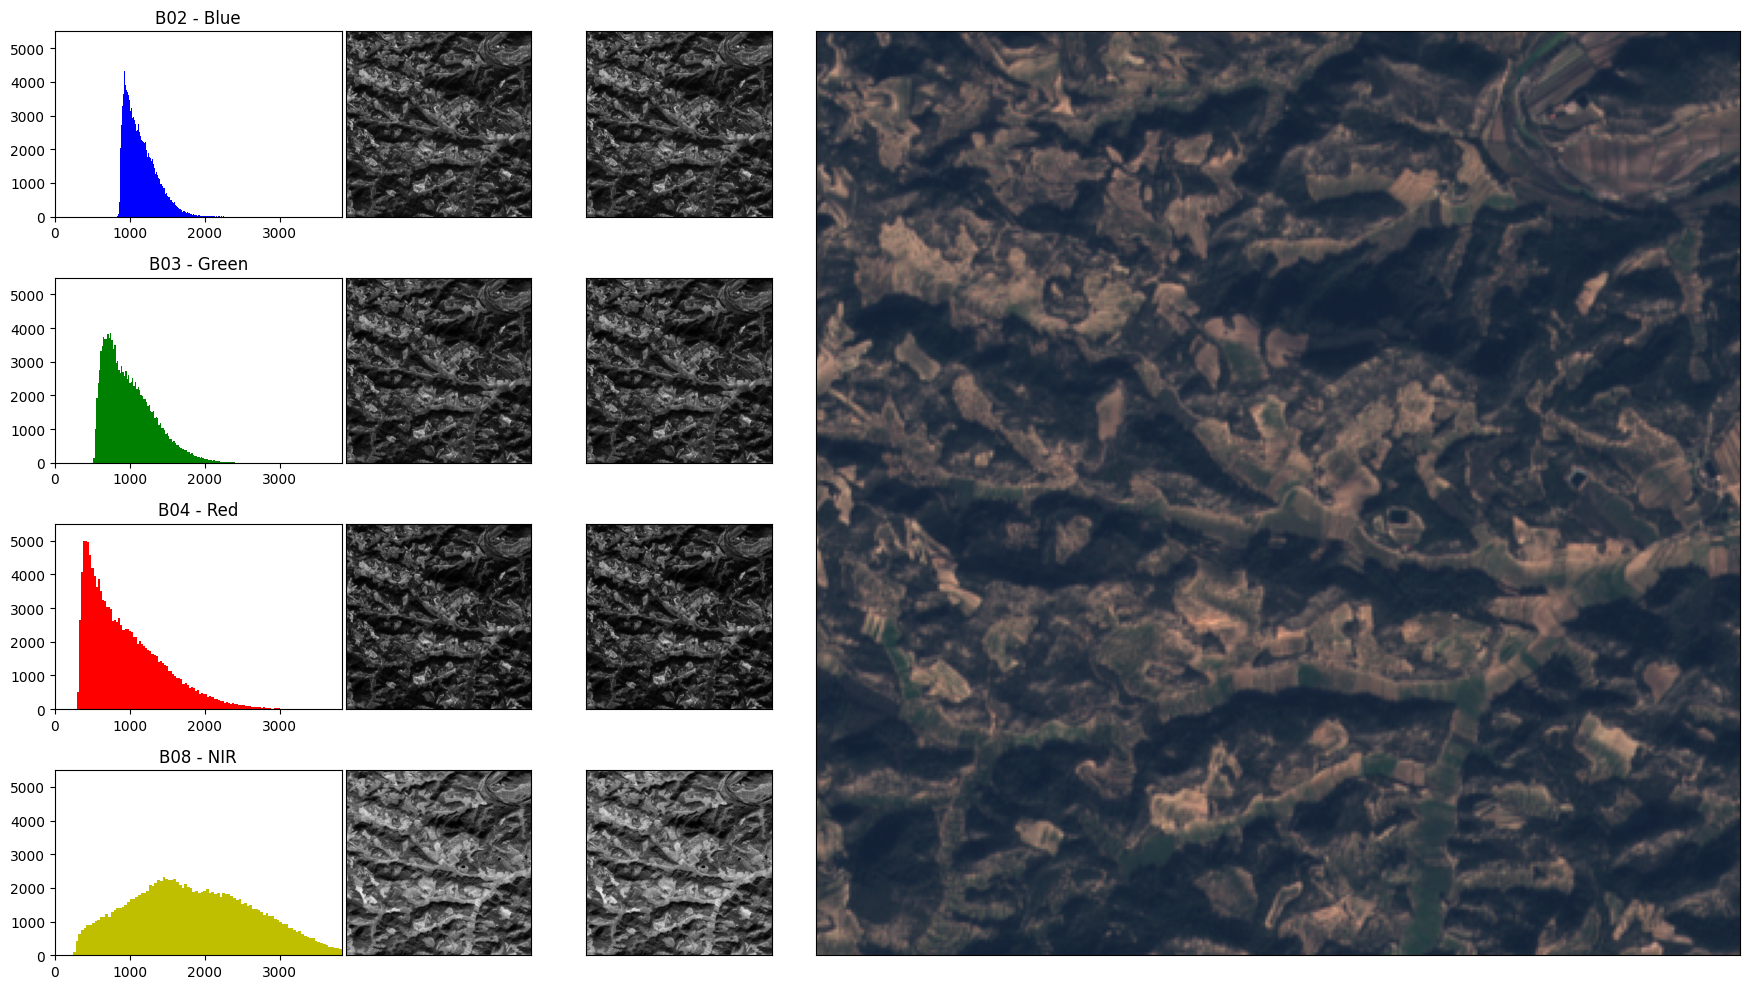

In [331]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02.isel(time=0)
B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03.isel(time=0)
B04 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04.isel(time=0)
B08 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08.isel(time=0)

bands = [
    {'title': 'B02 - Blue',  'band': B02, 'plotc': 'b'},
    {'title': 'B03 - Green', 'band': B03, 'plotc': 'g'},
    {'title': 'B04 - Red',   'band': B04, 'plotc': 'r'}
    ,{'title': 'B08 - NIR',   'band': B08, 'plotc': 'y'}
]

print(f'{[b["title"] for b in bands]}')
bmean = np.mean([np.array(b["band"]) for b in bands], axis=0)
print(f'{bmean.shape}, {bmean.dtype}')

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(nrows=len(bands), ncols=4, width_ratios=[2, 2, 2, 7])

xmin = 0
xmax = np.max(np.concatenate((np.array(B02).flatten(), np.array(B03).flatten(), np.array(B04).flatten())))
print(f'xlim: {xmin} - {xmax}')

ymin = 0
ymax = 5500

for n,band in enumerate(bands):
    ax = fig.add_subplot(gs[n, 0])
    ax.hist(np.array(band['band']).flatten(), bins=128, facecolor=band['plotc'])
    #ax.hist(blue8.astype("float32").flatten(), bins=100, facecolor='b')
    ax.set_title(band['title'])
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_ylim((ymin,ymax))
    ax.set_xlim((xmin,xmax))

    axim = fig.add_subplot(gs[n, 1])
    axim.imshow(band['band'], cmap='gray')
    axim.set_xticks([])
    axim.set_yticks([])

    axim = fig.add_subplot(gs[n, 2])
    axim.imshow(band['band'], cmap='gray')
    axim.set_xticks([])
    axim.set_yticks([])

red8 = np.array((B04 / 16).astype(np.uint8))
green8 = np.array((B03 / 16).astype(np.uint8))
blue8 = np.array((B02 / 16).astype(np.uint8))

axim = fig.add_subplot(gs[:, -1])
rgb3 = np.dstack((red8, green8, blue8))
axim.imshow(rgb3)
axim.set_xticks([])
axim.set_yticks([])

fig.tight_layout()
fig.subplots_adjust(wspace=-0.1)

plt.show()

(133956,) uint8
[61 62 73 67 71 85 98 78 74 67]


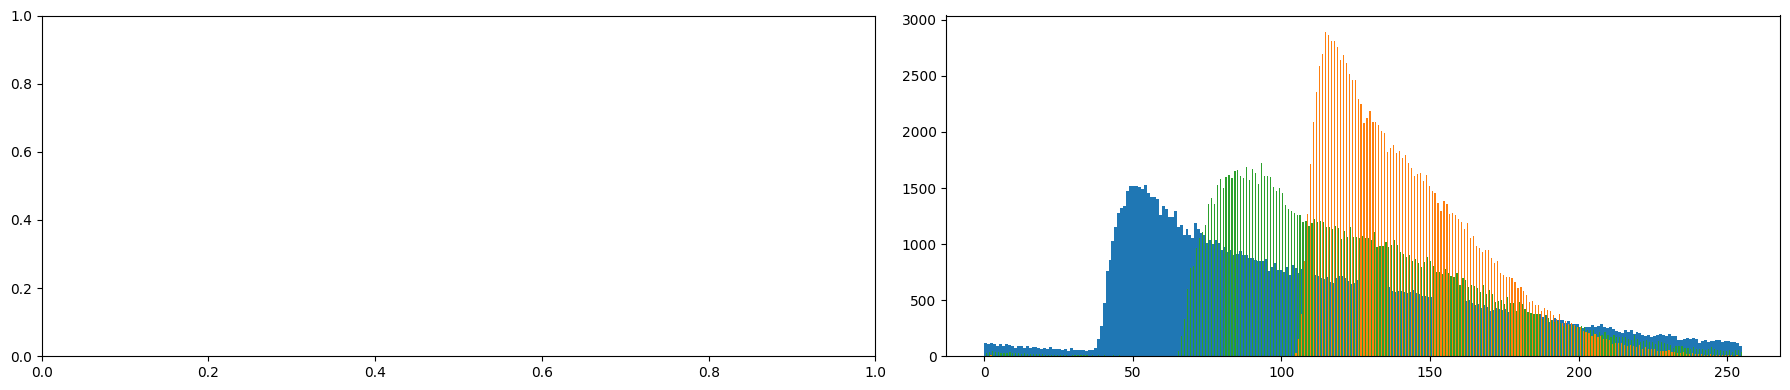

In [119]:
flatred = fRed.flatten()
print(flatred.shape, flatred.dtype)
print(flatred[0:10])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
plt.hist([fRed.flatten()], bins=256)
plt.hist([fBlue.flatten(), fGreen.flatten()], bins=256)

#for n,ax in enumerate(axes):
#    ax.axes.get_xaxis().set_ticklabels([])
#    ax.axes.get_yaxis().set_ticklabels([])
#    ax.axes.axis('tight')
#    ax.set_xlabel('')
#    ax.set_ylabel('')
#    ax.set_title(f'Month: {i+1}')

plt.tight_layout()
plt.show()